In [1]:
!pip install umap-learn
!pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 64.7 MB/s eta 0:00:00:00:010:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl.metadata (3.1 kB)
Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=819466 sha256=36306c93a382b775d5c21fe37bd16c02b353b63d8d2928a55e05a857a469807c
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.8
    Uninstalling Cython-3.0.8:
      Successfully uninstalled Cython-3.0.8


In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
import hdbscan

import torch.nn.functional as F
import torch

from torch import Tensor
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset, Dataset
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm

import umap

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

2024-05-18 17:58:38.666260: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 17:58:38.666356: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 17:58:38.786678: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [5]:
table_path = "/kaggle/input/full-processed-dataset/full_processed_dataset.csv"
data = pd.read_csv(table_path)
data.dropna(axis=0, how='any', inplace=True)
data.parsed_text = data.parsed_text.astype(str)

data.head()

,url,base_category_nm,parsed_text
0,https://aspect-school.ru,Образование,курс маникюр школа обучение ученик мастер ногт...
1,https://rlagency.ru,Развлечения,билет купить руб подробный любовь дк павлово с...
2,https://kozlovatravel.u-on.ru,Развлечения,Автоматизированная система U ON Travel Забыли ...
3,https://rootsyou.tilda.ws,Красота,крем мыло баттеры аромароллер косметика душа п...
4,https://esk.one/p/wadgpcigy2vveo,Образование,прототип блок схема поддержка mind esk one сер...


In [6]:
lol = []
for i in range(data.shape[0]):
    if data.loc[i, 'parsed_text'].find('Страница входа Восстановить Зарегистрироваться') != -1:
        lol.append(i)
print(lol)

[87, 133, 230, 568, 785, 795, 1075, 1216, 1361, 1365, 1638, 1658, 1953, 2061, 2301, 2360, 2519, 2696, 3162, 3186, 3236, 3376, 4330, 4577, 4680, 4882, 4923, 5079, 5173, 5225, 5266, 5303, 5626, 5694, 5740, 5994, 6067, 6232, 6233, 6513, 7210, 7651, 8013, 8041, 8059, 8097, 8101, 8434, 8509, 8552, 8902, 8934, 9094, 9133, 9184, 9369, 9453, 9464, 9575, 9621, 9775, 9864, 9865, 10375, 10425, 10538, 10663, 10711, 10768, 10857, 10868, 11489, 11538, 11568, 11701, 11784, 11919, 12251, 12295, 12320, 12511, 12554, 12644, 12837, 13174, 13203, 13378, 14085, 14376, 14405, 14552, 14719, 15068, 15206, 15251, 15270, 15815, 15959, 15994, 16377, 16435, 16849, 16947, 16999, 17426, 17707, 17779, 17808, 18204, 18273, 18602, 18758, 18821, 18994, 19279, 19609, 19975, 20083, 20227, 20418, 20435, 20563, 20685, 20802, 21165, 21229, 21464, 21499, 21527, 21532, 21586, 21646, 21903, 22078, 22088, 22259, 22965, 22974, 23037, 23105, 23189, 23193, 23372, 23799, 23825, 23978, 24151, 24270, 24292, 24900, 24908, 25125, 25216

In [7]:
data.loc[lol, :]

,url,base_category_nm,parsed_text
87,https://lk.masha.fit,Образование,Страница входа Восстановить Зарегистрироваться...
133,https://course.kaina.ru,Образование,Страница входа Восстановить Зарегистрироваться...
230,https://kurs.speechka.online,Образование,Страница входа Восстановить Зарегистрироваться...
568,https://dociureva.com,Образование,Страница входа Восстановить Зарегистрироваться...
785,https://kurs.smolyaninovablog.ru,Образование,Страница входа Восстановить Зарегистрироваться...
...,...,...,...
36386,https://turkeeva.ru,Образование,Страница входа Восстановить Зарегистрироваться...
36687,https://kidspravo.ru,Цифровые услуги,Страница входа Восстановить Зарегистрироваться...
36701,https://tatiananovinskaya.ru,Образование,Страница входа Восстановить Зарегистрироваться...
36935,https://larina-m.ru,Образование,Страница входа Восстановить Зарегистрироваться...


In [10]:
data.drop(index=lol, inplace=True)

KeyError: '[87, 133, 230, 568, 785, 795, 1075, 1216, 1361, 1365, 1638, 1658, 1953, 2061, 2301, 2360, 2519, 2696, 3162, 3186, 3236, 3376, 4330, 4577, 4680, 4882, 4923, 5079, 5173, 5225, 5266, 5303, 5626, 5694, 5740, 5994, 6067, 6232, 6233, 6513, 7210, 7651, 8013, 8041, 8059, 8097, 8101, 8434, 8509, 8552, 8902, 8934, 9094, 9133, 9184, 9369, 9453, 9464, 9575, 9621, 9775, 9864, 9865, 10375, 10425, 10538, 10663, 10711, 10768, 10857, 10868, 11489, 11538, 11568, 11701, 11784, 11919, 12251, 12295, 12320, 12511, 12554, 12644, 12837, 13174, 13203, 13378, 14085, 14376, 14405, 14552, 14719, 15068, 15206, 15251, 15270, 15815, 15959, 15994, 16377, 16435, 16849, 16947, 16999, 17426, 17707, 17779, 17808, 18204, 18273, 18602, 18758, 18821, 18994, 19279, 19609, 19975, 20083, 20227, 20418, 20435, 20563, 20685, 20802, 21165, 21229, 21464, 21499, 21527, 21532, 21586, 21646, 21903, 22078, 22088, 22259, 22965, 22974, 23037, 23105, 23189, 23193, 23372, 23799, 23825, 23978, 24151, 24270, 24292, 24900, 24908, 25125, 25216, 25486, 25707, 25902, 26122, 26164, 26218, 26273, 26278, 26345, 26625, 26728, 26756, 26840, 26999, 27054, 27137, 27229, 27308, 27759, 28005, 28505, 28702, 28713, 28756, 29001, 29050, 29252, 29518, 29548, 29690, 29918, 30014, 30044, 30155, 30286, 30373, 30646, 30719, 30777, 30865, 31209, 31728, 31813, 31964, 31974, 32074, 32143, 32209, 32386, 32500, 32517, 32773, 32790, 32812, 32866, 33007, 33321, 33503, 33941, 34374, 34416, 34466, 34624, 34945, 35064, 35486, 35692, 35884, 36091, 36255, 36386, 36687, 36701, 36935, 36941] not found in axis'

In [11]:
data['base_category_nm'].unique()

array(['Образование', 'Развлечения', 'Красота',
       'Продажа различных товаров', 'Авиабилеты', 'Одежда',
       'Дом и ремонт', 'Одежда и аксессуары', 'Связь и телеком',
       'Медицина', 'Салоны красоты и здоровья',
       'Электроника и бытовая техника', 'Различные услуги',
       'Подарки и сувениры', 'Цифровые услуги',
       'Заведения общественного питания', 'Автозапчасти и автосервисы',
       'Спорт', 'Зоомагазины и ветеринарные клиники', 'Транспорт',
       'Продукты', 'Рукоделие и творчество',
       'Адвокаты и юридические услуги', 'Ювелирные изделия и часы',
       'Книги и канцтовары', 'Отели', 'Печать и сканирование',
       'Танцевальные залы, школы и студии', 'Финансовые услуги', 'Цветы',
       'Магазины игрушек и хобби-товаров', 'Ремонт компьютеров',
       'Жилищно-коммунальные услуги', 'Аптеки', 'Спорттовары',
       'Курьерские услуги', 'Фотостудии', 'Оптика', 'Топливо',
       'Химчистка', 'Ателье и ремонт одежды', 'Ломбарды',
       'Клубы видеоигр', 'Бары, п

In [13]:
def draw_wordcloud(texts, max_words=1000, width=1000, height=500):
    wordcloud = WordCloud(background_color='white', max_words=max_words,
                          width=width, height=height)
    
    joint_texts = ' '.join(list(texts))
    wordcloud.generate(joint_texts)
    return wordcloud.to_image()

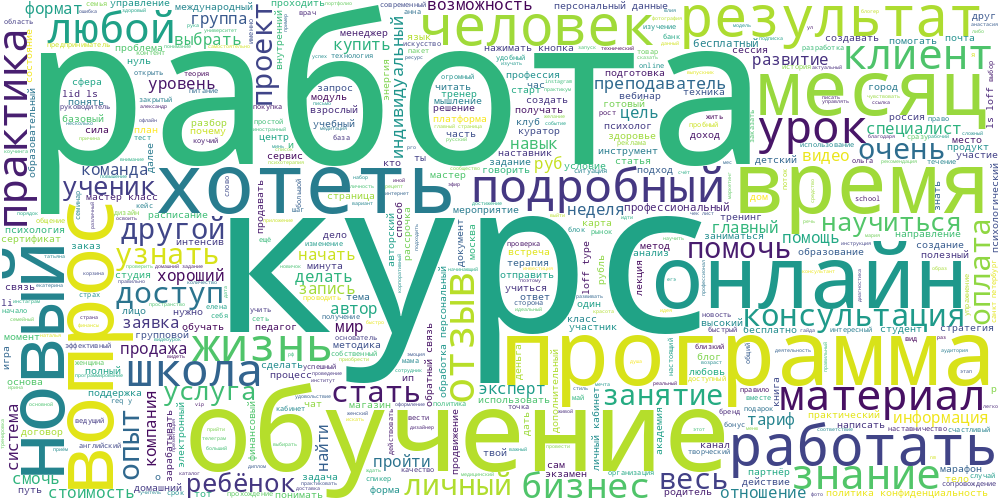

In [14]:
draw_wordcloud(data[data["base_category_nm"] == 'Образование']["parsed_text"])

In [91]:
print('общий размер датасета', data.shape[0])
print('количество элементов не из образования', data[data['base_category_nm'] != 'Образование']['parsed_text'].count())
print('количество элементов из образования', data[data['base_category_nm'] == 'Образование']['parsed_text'].count())
print('максимальный размер строки в датасете', max(len(i) for i in data['parsed_text']))

общий размер датасета 36891
количество элементов не из образования 28527
количество элементов из образования 8364
максимальный размер строки в датасете 512


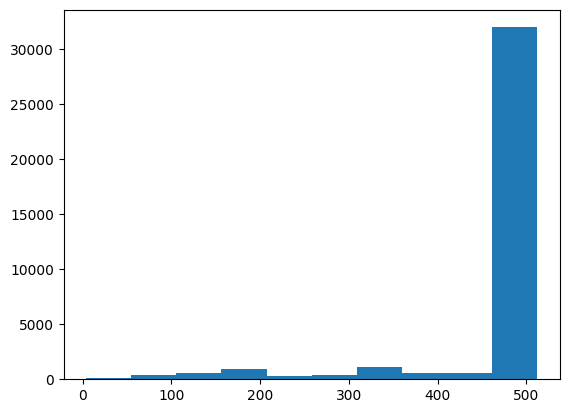

In [15]:
plt.hist([len(i) for i in data['parsed_text']])
plt.show()

In [16]:
tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-large')
model = AutoModel.from_pretrained('intfloat/multilingual-e5-large').to(device)

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

In [17]:
data['text'] = data['parsed_text'].apply(lambda x: "query: " + x)
data.head()

,url,base_category_nm,parsed_text,text
0,https://aspect-school.ru,Образование,курс маникюр школа обучение ученик мастер ногт...,query: курс маникюр школа обучение ученик маст...
1,https://rlagency.ru,Развлечения,билет купить руб подробный любовь дк павлово с...,query: билет купить руб подробный любовь дк па...
2,https://kozlovatravel.u-on.ru,Развлечения,Автоматизированная система U ON Travel Забыли ...,query: Автоматизированная система U ON Travel ...
3,https://rootsyou.tilda.ws,Красота,крем мыло баттеры аромароллер косметика душа п...,query: крем мыло баттеры аромароллер косметика...
4,https://esk.one/p/wadgpcigy2vveo,Образование,прототип блок схема поддержка mind esk one сер...,query: прототип блок схема поддержка mind esk ...


In [19]:
dataset = Dataset.from_pandas(data[data["base_category_nm"] == 'Образование'])

In [20]:
%%time

TEST_SIZE = 0.3
SPLIT_RANDOM_SEED = 42
MAX_LENGTH = 512

# batch_dict = dataset.map(encode, batched=True, remove_columns="text")
batch_dict = tokenizer(dataset["text"], max_length=512, padding=True, truncation=True, return_tensors='pt')

trans_dataset = TensorDataset(batch_dict['input_ids'], batch_dict['attention_mask'])

CPU times: user 6.52 s, sys: 443 ms, total: 6.97 s
Wall time: 3.32 s


In [22]:
batch_size = 1
data_loader = DataLoader(trans_dataset, batch_size=batch_size, shuffle=False)

In [23]:
%%time

def average_pool(last_hidden_states: Tensor, attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

model.eval()
result = None
for input_ids, attention_mask in tqdm(data_loader, desc=f'Trans'):
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    
    out = model(input_ids, attention_mask=attention_mask)
    embeddings = average_pool(out.last_hidden_state, attention_mask)
    
    res = embeddings.cpu().detach().numpy().astype("float")
    if result is None:
        result = res.copy()
    else:
        result = np.append(result, res, axis=0)

Trans: 100%|██████████| 8364/8364 [07:31<00:00, 18.52it/s]

CPU times: user 7min 28s, sys: 4.33 s, total: 7min 32s
Wall time: 7min 31s


In [24]:
result.shape

(8364, 1024)

In [25]:
import gc
torch.cuda.empty_cache()
gc.collect()

90

In [26]:
kmeans = KMeans(n_clusters=4).fit(result)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


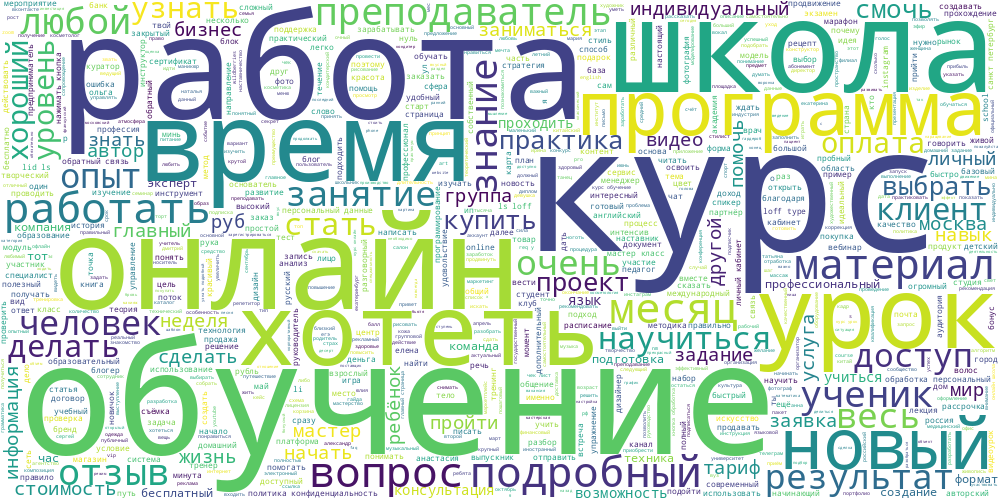

In [26]:
draw_wordcloud(data[data["base_category_nm"] == 'Образование'][kmeans.labels_ == 0].parsed_text)

In [27]:
data[data["base_category_nm"] == 'Образование'][kmeans.labels_ == 0]

,url,base_category_nm,parsed_text,text
15,https://sodrsystem.ru,Образование,содружество р sodruzhestvo amway бизнес друг л...,query: содружество р sodruzhestvo amway бизнес...
29,https://artemovsergey.com,Образование,Обучение и курсы по Канбан методу Сертифициров...,query: Обучение и курсы по Канбан методу Серти...
69,https://moskills.kassa.bizon365.ru/buy/moskill...,Образование,Школа маркетплейсов Moskills ВЕБИНАР ШАГОВ ДЛЯ...,query: Школа маркетплейсов Moskills ВЕБИНАР ША...
75,https://housedance.pro,Образование,Танцуй где когда и в чем тебе удобно Подбирай ...,query: Танцуй где когда и в чем тебе удобно По...
99,https://legkoved.ru,Образование,Легковед Л Е К О В Е Д Блог Голодание Основате...,query: Легковед Л Е К О В Е Д Блог Голодание О...
...,...,...,...,...
36949,https://lifeacademy.space,Образование,تسجيل الدخول تفاصيل تسجيل الدخول تذكرني نسيت ك...,query: تسجيل الدخول تفاصيل تسجيل الدخول تذكرني...
36954,https://massageschool.tb.ru/product-vkxunkt,Образование,Товар Товар Главная К покупкам К покупкам Наза...,query: Товар Товар Главная К покупкам К покупк...
36965,https://art-fusion.me,Образование,Студия современного творчества в Челябинске уд...,query: Студия современного творчества в Челяби...
37010,https://dharma-jyotish-siddhanta-yogi-ashram.com,Образование,сатьят наст паро дхармах Дхарма Джйотиш Сиддха...,query: сатьят наст паро дхармах Дхарма Джйотиш...


In [ ]:
draw_wordcloud(data[data["base_category_nm"] == 'Образование'][kmeans.labels_ == 1].parsed_text)

In [ ]:
data[data["base_category_nm"] == 'Образование'][kmeans.labels_ == 1]

,url,base_category_nm,parsed_text,text
10,https://bargana.space,Образование,li bargana nm name space специалист lid ls lof...,query: li bargana nm name space специалист lid...
56,https://dnative.ru,Образование,smm dnative подписаться блог подкаст стратегия...,query: smm dnative подписаться блог подкаст ст...
57,https://webinar.wildmanager.ru,Образование,зарегистрироваться товар вебинар гайда оформле...,query: зарегистрироваться товар вебинар гайда ...
91,https://voitenko.online,Образование,меню доступ сопровождение тренировка работа тв...,query: меню доступ сопровождение тренировка ра...
95,https://fin-intensive.ru,Образование,урок бизнес отчёт финансовый управленческий ин...,query: урок бизнес отчёт финансовый управленче...
...,...,...,...,...
37024,https://highlevel.tb.ru/highlevelschool,Образование,курс выбрать урок подробный новый онлайн творч...,query: курс выбрать урок подробный новый онлай...
37030,https://pixel-map.ru,Образование,дизайн курс работа ux дизайнер li директор ui ...,query: дизайн курс работа ux дизайнер li дирек...
37033,https://specialnoe-predlozhenie.tb.ru,Образование,марафон желание specialnoe predlozhenie blinov...,query: марафон желание specialnoe predlozhenie...
37045,https://yamunacake.ru,Образование,торт кг человек подробный руб вес команда отзы...,query: торт кг человек подробный руб вес коман...


In [ ]:
draw_wordcloud(data[data["base_category_nm"] == 'Образование'][kmeans.labels_ == 2].parsed_text)

In [ ]:
data[data["base_category_nm"] == 'Образование'][kmeans.labels_ == 2]

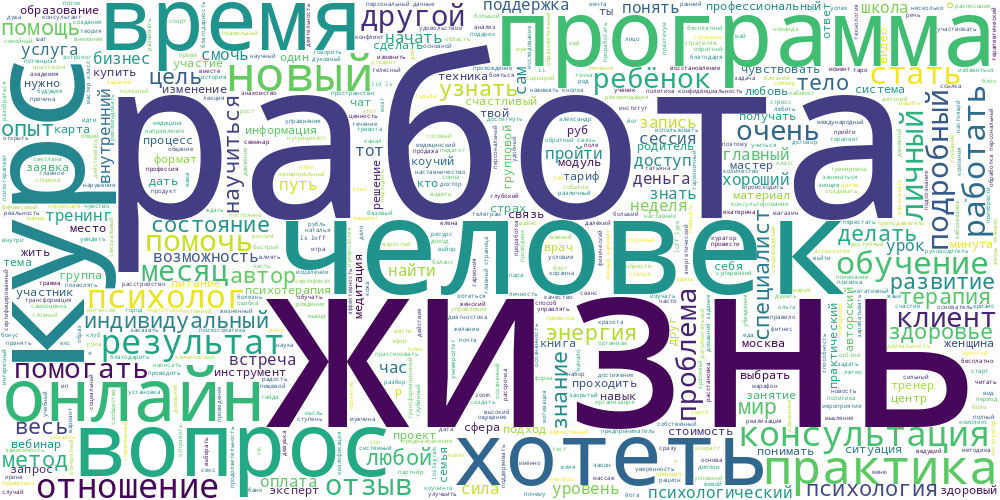

In [ ]:
draw_wordcloud(data[data["base_category_nm"] == 'Образование'][kmeans.labels_ == 3].parsed_text)

In [ ]:
data[data["base_category_nm"] == 'Образование'][kmeans.labels_ == 3]

,url,base_category_nm,parsed_text,text
12,https://larisasitnikova.ru/#top,Образование,тренинг развитие индивидуальный навык бизнес ц...,query: тренинг развитие индивидуальный навык б...
18,https://sviyash-center.ru,Образование,свияша тренинг александр найти любовь отзыв кн...,query: свияша тренинг александр найти любовь о...
35,https://uptrend.club,Образование,курс человек жизнь узнать научиться подавление...,query: курс человек жизнь узнать научиться под...
49,https://sashaxarlova.ru,Образование,сессия хотеть работа работать бизнес деньга ко...,query: сессия хотеть работа работать бизнес де...
50,https://elviralukashina.blogspot.com,Образование,ребёнок эльвира автор школа лукашин рубрика ре...,query: ребёнок эльвира автор школа лукашин руб...
...,...,...,...,...
37050,https://margarita-vitaliy.com,Образование,тренировка тело тнг твой упражнение руб маргар...,query: тренировка тело тнг твой упражнение руб...
37075,https://alekhina-agency.ru/salesworkshop,Образование,продажа счастие продукт бонус июль долгосрочны...,query: продажа счастие продукт бонус июль долг...
37078,https://yanamikitenko.tilda.ws,Образование,тренинг тело доступ прийти боль травма избавит...,query: тренинг тело доступ прийти боль травма ...
37098,https://arinastrelets.com,Образование,видео опыт мастер класс партнёр оплата сфера к...,query: видео опыт мастер класс партнёр оплата ...


In [ ]:
scaled_penguin_data = StandardScaler().fit_transform(result)

In [35]:
%%time

reducer = umap.UMAP()
embedding = reducer.fit_transform(scaled_penguin_data)
embedding.shape

CPU times: user 55.6 s, sys: 1.14 s, total: 56.8 s
Wall time: 30.5 s


(8364, 2)

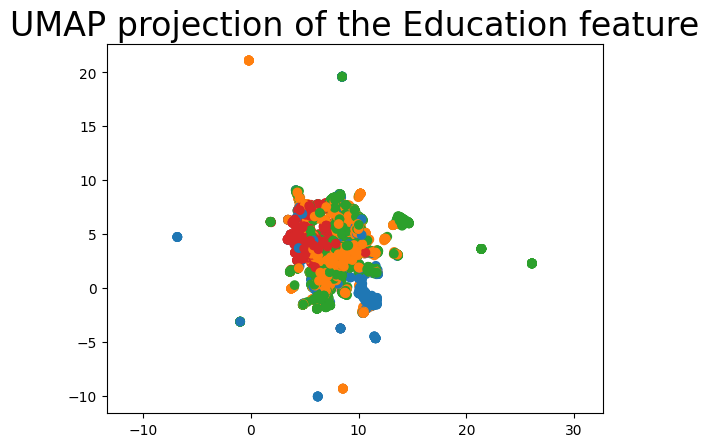

In [36]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in kmeans.labels_])

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Education feature', fontsize=24);

In [37]:
dbscan = DBSCAN(eps=0.05).fit(result)

In [38]:
set(dbscan.labels_)

{-1, 0, 1, 2, 3, 4, 5}

In [39]:
embedding[dbscan.labels_ == 0]

array([[-0.18555403, 21.110754  ],
       [-0.18556042, 21.110767  ],
       [-0.18557025, 21.11079   ],
       [-0.18558054, 21.110815  ],
       [-0.18558991, 21.11083   ],
       [-0.18550308, 21.1107    ],
       [-0.18557055, 21.110785  ],
       [-0.1855661 , 21.110783  ],
       [-0.18556926, 21.110792  ],
       [-0.18558966, 21.11083   ],
       [-0.18558407, 21.110823  ]], dtype=float32)

/tmp/ipykernel_34/3856471368.py:4: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(


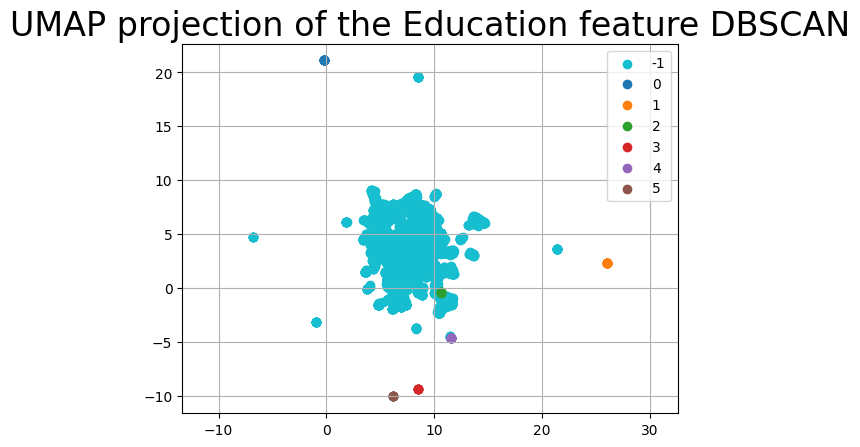

In [40]:
# 0.5
fig, ax = plt.subplots()
for lbl in np.arange(-1, 6):
    ax.scatter(
        embedding[dbscan.labels_ == lbl][:, 0],
        embedding[dbscan.labels_ == lbl][:, 1],
        c=sns.color_palette()[lbl],
        label=lbl)

ax.legend()
ax.grid(True)

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Education feature DBSCAN', fontsize=24)

plt.show()

/tmp/ipykernel_34/1987901271.py:4: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(


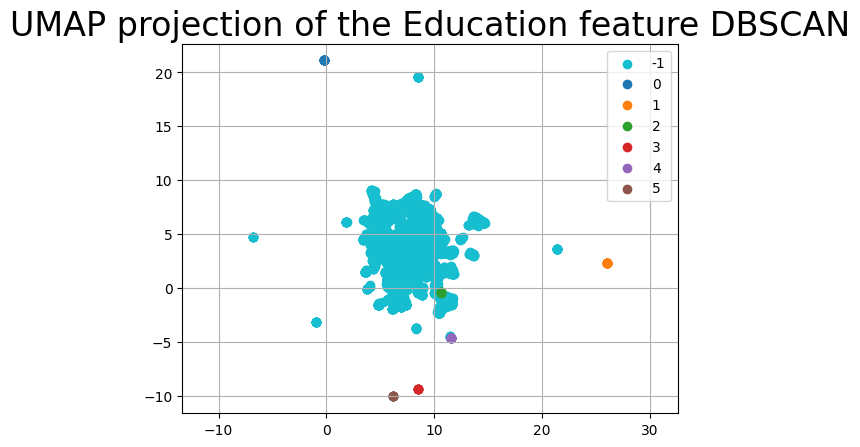

In [42]:
# 0.05
fig, ax = plt.subplots()
for lbl in np.arange(-1, 6):
    ax.scatter(
        embedding[dbscan.labels_ == lbl][:, 0],
        embedding[dbscan.labels_ == lbl][:, 1],
        c=sns.color_palette()[lbl],
        label=lbl)

ax.legend()
ax.grid(True)

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Education feature DBSCAN', fontsize=24)

plt.show()

/tmp/ipykernel_34/1577030775.py:4: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(


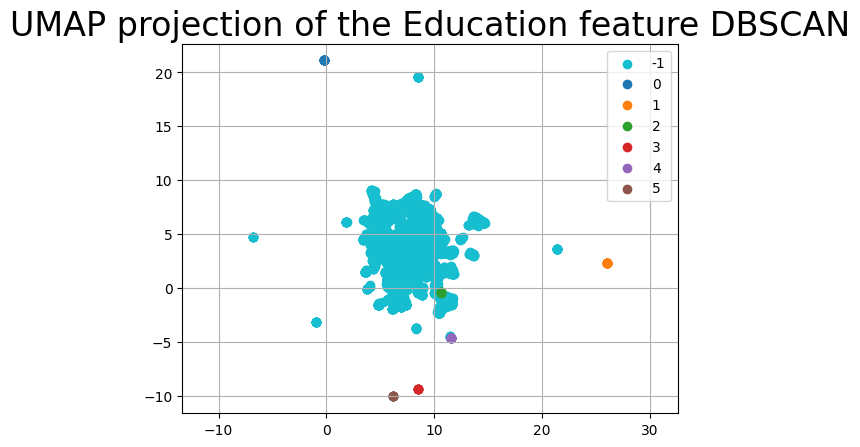

In [43]:
# 5
fig, ax = plt.subplots()
for lbl in np.arange(-1, 6):
    ax.scatter(
        embedding[dbscan.labels_ == lbl][:, 0],
        embedding[dbscan.labels_ == lbl][:, 1],
        c=sns.color_palette()[lbl],
        label=lbl)

ax.legend()
ax.grid(True)

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Education feature DBSCAN', fontsize=24)

plt.show()

In [44]:
from sklearn.decomposition import PCA

kek = PCA(n_components=10).fit_transform(result)

In [45]:
spectr = SpectralClustering(n_jobs=-1).fit(result[:1000])

/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:393: UserWarning: Exited at iteration 599 with accuracies 
[6.46611447e-15 4.11382582e-06 5.60363193e-06 2.70068961e-06
 3.23515347e-06 1.02027392e-05 2.12663398e-05 1.36554256e-05
 9.70288840e-06]
not reaching the requested tolerance 1.4901161193847656e-05.
Use iteration 525 instead with accuracy 
7.049872591760197e-06.

  _, diffusion_map = lobpcg(
/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:393: UserWarning: Exited postprocessing with accuracies 
[1.89509334e-15 3.69825328e-06 5.42375299e-06 3.26804922e-06
 3.36922520e-06 6.39653378e-06 7.89675108e-06 2.14426222e-05
 1.19572819e-05]
not reaching the requested tolerance 1.4901161193847656e-05.
  _, diffusion_map = lobpcg(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:420: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  e

In [46]:
set(spectr.labels_)

{0, 1, 2, 3, 4, 5}

In [47]:
from collections import Counter
lol = Counter(spectr.labels_)
lol

Counter({0: 995, 4: 1, 3: 1, 2: 1, 1: 1, 5: 1})

/tmp/ipykernel_34/738066633.py:3: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(


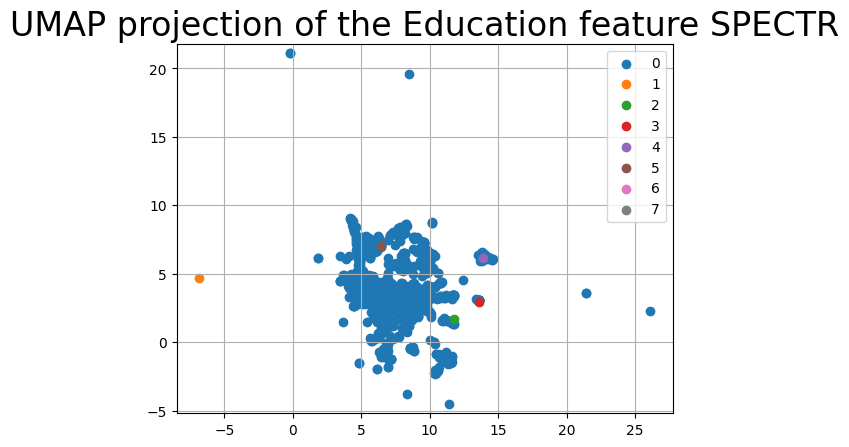

In [48]:
fig, ax = plt.subplots()
for lbl in np.arange(0, 8):
    ax.scatter(
        embedding[:1000][spectr.labels_ == lbl][:, 0],
        embedding[:1000][spectr.labels_ == lbl][:, 1],
        c=sns.color_palette()[lbl],
        label=lbl)

ax.legend()
ax.grid(True)

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Education feature SPECTR', fontsize=24)

plt.show()

In [49]:
data[data["base_category_nm"] == 'Образование'][:1000][spectr.labels_ == 7]

,url,base_category_nm,parsed_text,text


In [50]:
hdbscan_model = hdbscan.HDBSCAN(cluster_selection_epsilon=5).fit(result)

In [51]:
from collections import Counter
lol = Counter(hdbscan_model.labels_)
lol

Counter({-1: 6697,
         20: 1350,
         21: 128,
         17: 19,
         1: 18,
         8: 17,
         7: 12,
         9: 12,
         2: 11,
         6: 10,
         18: 9,
         10: 9,
         11: 9,
         19: 8,
         5: 8,
         14: 7,
         3: 6,
         15: 6,
         4: 6,
         13: 6,
         0: 6,
         16: 5,
         12: 5})

In [52]:
set(hdbscan_model.labels_)

{-1,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21}

In [55]:
data['ЕГЭ'] = data['text'].apply(lambda x: (x.find('ЕГЭ') != -1) or (x.find('егэ') != -1))

In [69]:
new_data = data[data["base_category_nm"] == 'Образование']
new_data['cluster'] = hdbscan_model.labels_

/tmp/ipykernel_34/977423145.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['cluster'] = hdbscan_model.labels_


In [70]:
new_data[new_data['ЕГЭ'] == True]['cluster'].value_counts()

cluster
-1     159
 20     83
 21      1
 6       1
Name: count, dtype: int64

In [71]:
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

ege_points = embedding[(new_data['ЕГЭ'] == True)]

In [72]:
ege_distances = euclidean_distances(ege_points, ege_points)

mean_ege_distance = np.mean(ege_distances)
print(f"Среднее расстояние внутри группы ЕГЭ: {mean_ege_distance}")

Среднее расстояние внутри группы ЕГЭ: 1.7216148376464844


In [73]:
unique_labels = new_data['cluster'].unique()

mean_distances_within_groups = {}
for lbl in unique_labels:
    if lbl == -1:
        continue
    group_points = embedding[(new_data['cluster'] == lbl)]
    group_distances = euclidean_distances(group_points, group_points)
    mean_distance = np.mean(group_distances)
    mean_distances_within_groups[lbl] = mean_distance

for lbl, mean_distance in mean_distances_within_groups.items():
    print(f"Среднее расстояние внутри группы {lbl}: {mean_distance}")

Среднее расстояние внутри группы 21: 0.4471885859966278
Среднее расстояние внутри группы 20: 4.1245856285095215
Среднее расстояние внутри группы 7: 4.8263613280141726e-05
Среднее расстояние внутри группы 19: 0.036604396998882294
Среднее расстояние внутри группы 18: 0.027710143476724625
Среднее расстояние внутри группы 3: 0.007429314777255058
Среднее расстояние внутри группы 17: 0.0020319162867963314
Среднее расстояние внутри группы 8: 0.00014865020057186484
Среднее расстояние внутри группы 10: 0.17931528389453888
Среднее расстояние внутри группы 16: 0.029443789273500443
Среднее расстояние внутри группы 1: 0.0013024347135797143
Среднее расстояние внутри группы 6: 0.0018161949701607227
Среднее расстояние внутри группы 15: 0.014828077517449856
Среднее расстояние внутри группы 4: 0.00036808609729632735
Среднее расстояние внутри группы 9: 0.006443260237574577
Среднее расстояние внутри группы 2: 0.009186699986457825
Среднее расстояние внутри группы 13: 0.0369197241961956
Среднее расстояние в

In [74]:
mean_distances_between_groups = {}

for lbl1 in unique_labels:
    if lbl1 == -1:
        continue
    for lbl2 in unique_labels:
        if lbl2 == -1 or lbl1 >= lbl2:
            continue
        group1_points = embedding[(new_data['cluster'] == lbl1)]
        group2_points = embedding[(new_data['cluster'] == lbl2)]
        distances_between_groups = euclidean_distances(group1_points, group2_points)
        mean_distance = np.mean(distances_between_groups)
        mean_distances_between_groups[(lbl1, lbl2)] = mean_distance

for (lbl1, lbl2), mean_distance in mean_distances_between_groups.items():
    print(f"Среднее расстояние между группами {lbl1} и {lbl2}: {mean_distance}")

Среднее расстояние между группами 20 и 21: 7.495151042938232
Среднее расстояние между группами 7 и 21: 20.62921714782715
Среднее расстояние между группами 7 и 20: 19.884109497070312
Среднее расстояние между группами 7 и 19: 16.90961456298828
Среднее расстояние между группами 7 и 18: 22.682424545288086
Среднее расстояние между группами 7 и 17: 27.780115127563477
Среднее расстояние между группами 7 и 8: 32.33660888671875
Среднее расстояние между группами 7 и 10: 13.02322769165039
Среднее расстояние между группами 7 и 16: 23.204288482666016
Среднее расстояние между группами 7 и 15: 19.646663665771484
Среднее расстояние между группами 7 и 9: 21.540775299072266
Среднее расстояние между группами 7 и 13: 19.971750259399414
Среднее расстояние между группами 7 и 14: 15.241793632507324
Среднее расстояние между группами 7 и 12: 20.840412139892578
Среднее расстояние между группами 7 и 11: 22.159400939941406
Среднее расстояние между группами 19 и 21: 4.708283424377441
Среднее расстояние между групп

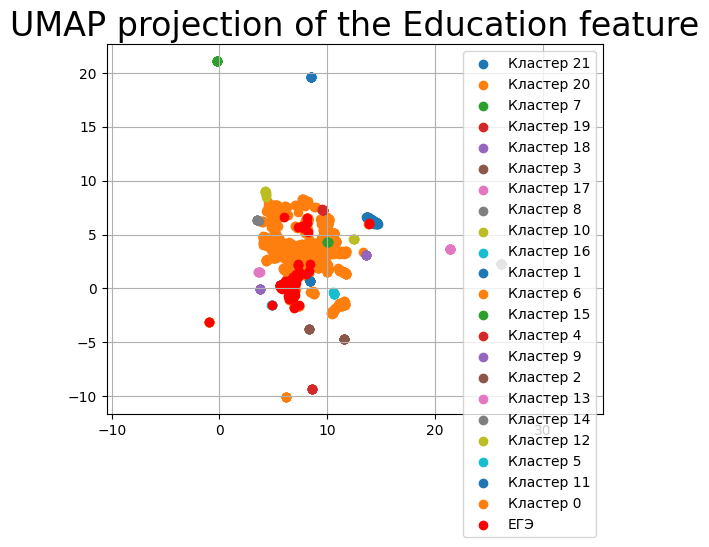

In [76]:
fig, ax = plt.subplots()
for lbl in unique_labels:
    if lbl == -1:
        continue
    ax.scatter(
        embedding[new_data['cluster'] == lbl][:, 0],
        embedding[new_data['cluster'] == lbl][:, 1],
        label=f'Кластер {lbl}'
    )

ax.scatter(
    ege_points[:, 0],
    ege_points[:, 1],
    c='red',
    label='ЕГЭ'
)

ax.legend()
ax.grid(True)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Education feature', fontsize=24)
plt.show()

In [58]:
new_data['cluster'].unique()

array([-1, 21, 20,  7, 19, 18,  3, 17,  8, 10, 16,  1,  6, 15,  4,  9,  2,
       13, 14, 12,  5, 11,  0])

In [59]:
new_data.to_csv('education.csv')

In [60]:
colors = ['#000000', '#ff0000', '#00ff00', '#0000ff', '#ff9900', '#99cc00',
'#cc00cc', '#ffcc00', '#33ccff', '#009900', '#cc99cc', '#ff3300',
'#66ffcc', '#99ffcc', '#ffcc99', '#ff9999', '#cccccc', '#993366',
'#ffcc66', '#669999', '#ff6600', '#6633ff', '#9966ff', '#6699cc',
'#339933']

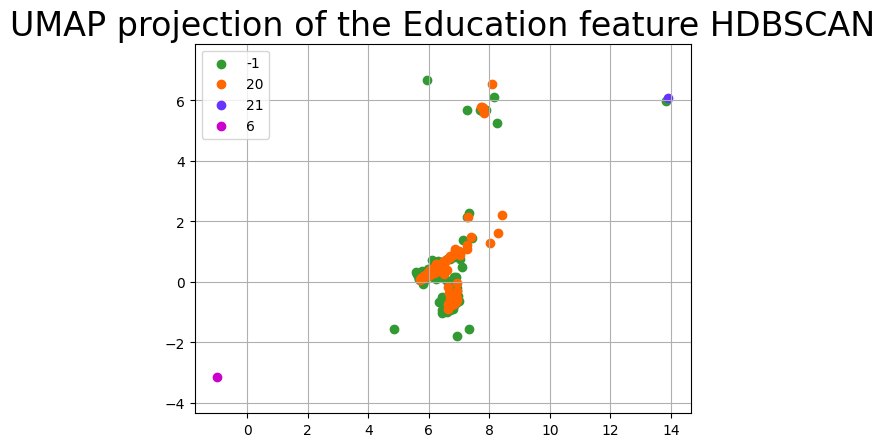

In [61]:
fig, ax = plt.subplots()
for lbl in [-1, 20, 21, 6]:
    ax.scatter(
        embedding[(new_data['ЕГЭ'] == True) & (new_data['cluster'] == lbl)][:, 0],
        embedding[(new_data['ЕГЭ'] == True) & (new_data['cluster'] == lbl)][:, 1],
        c=colors[lbl],
        label=lbl)

ax.legend()
ax.grid(True)

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Education feature HDBSCAN', fontsize=24)

plt.show()

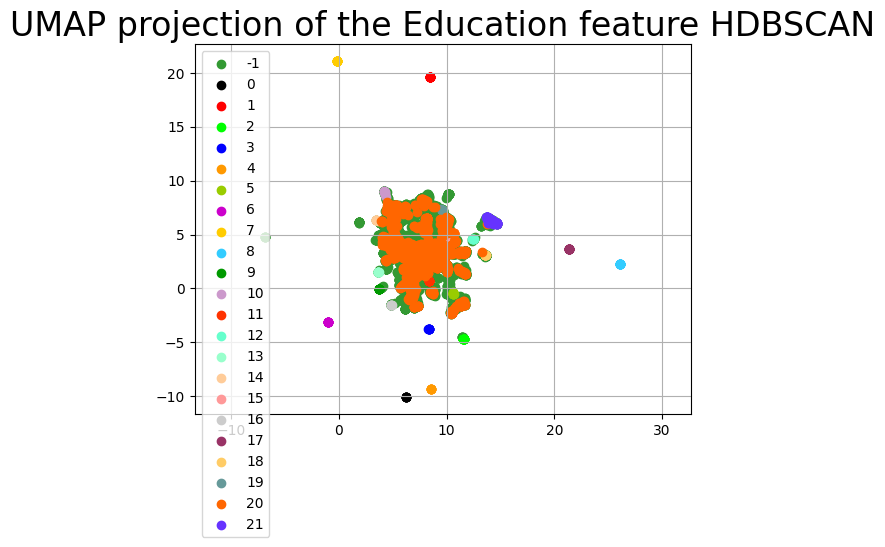

In [62]:
fig, ax = plt.subplots()
for lbl in np.arange(-1, 22):
    ax.scatter(
        embedding[hdbscan_model.labels_ == lbl][:, 0],
        embedding[hdbscan_model.labels_ == lbl][:, 1],
        c=colors[lbl],
        label=lbl)

ax.legend()
ax.grid(True)

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Education feature HDBSCAN', fontsize=24)

plt.show()

In [63]:
data[data["base_category_nm"] == 'Образование'][hdbscan_model.labels_ == 21]

,url,base_category_nm,parsed_text,text,ЕГЭ
78,https://twinsdoitschool.ru,Образование,персональный данные заказчик исполнитель услуг...,query: персональный данные заказчик исполнител...,False
141,https://бесплатные-парковки.рф,Образование,подписка персональный данные пользователь испо...,query: подписка персональный данные пользовате...,False
964,https://youknow-school.ru,Образование,персональный данные исполнитель заказчик обраб...,query: персональный данные исполнитель заказчи...,False
1134,https://edu.freeinfopro.ru,Образование,персональный данные обработка субъект оператор...,query: персональный данные обработка субъект о...,False
1882,https://wingsofchange.ru,Образование,персональный данные обработка оператор клиент ...,query: персональный данные обработка оператор ...,False
...,...,...,...,...,...
36367,https://academy-p2p.ru,Образование,персональный данные обработка заказчик исполни...,query: персональный данные обработка заказчик ...,False
36591,https://loveyourself.pro,Образование,персональный данные обработка оператор субъект...,query: персональный данные обработка оператор ...,False
36634,https://obida-poka.com,Образование,персональный заказчик данные исполнитель интен...,query: персональный заказчик данные исполнител...,False
36964,https://studylie.ru,Образование,пользователь информация маил персональный серв...,query: пользователь информация маил персональн...,False


In [65]:
data[data["base_category_nm"] == 'Образование'][hdbscan_model.labels_ == 20]

,url,base_category_nm,parsed_text,text,ЕГЭ
91,https://voitenko.online,Образование,меню доступ сопровождение тренировка работа тв...,query: меню доступ сопровождение тренировка ра...,False
120,https://tsuff.tb.ru/smarty_ogogo,Образование,занятие абонемент выбрать ребёнок чтение курс ...,query: занятие абонемент выбрать ребёнок чтени...,False
137,https://zaytsevatutor.tb.ru,Образование,английский язык занятие программа ребёнок курс...,query: английский язык занятие программа ребён...,False
227,https://etiquette.su,Образование,этикет обучение школа сервис игра юлиан шевчен...,query: этикет обучение школа сервис игра юлиан...,False
283,https://zaripov.club/bizbox,Образование,бизнес результат руб клиент личный встреча мод...,query: бизнес результат руб клиент личный встр...,False
...,...,...,...,...,...
36995,https://brevnovaelina.com/toyourself,Образование,курс задание путь шаг видеоурок эфир домашний ...,query: курс задание путь шаг видеоурок эфир до...,False
37015,https://60mn.ru,Образование,ребёнок обучение класс урок школа учебный прог...,query: ребёнок обучение класс урок школа учебн...,False
37030,https://pixel-map.ru,Образование,дизайн курс работа ux дизайнер li директор ui ...,query: дизайн курс работа ux дизайнер li дирек...,False
37050,https://margarita-vitaliy.com,Образование,тренировка тело тнг твой упражнение руб маргар...,query: тренировка тело тнг твой упражнение руб...,False


In [66]:
data[data["base_category_nm"] == 'Образование'][hdbscan_model.labels_ == 17]

,url,base_category_nm,parsed_text,text,ЕГЭ
1040,https://sredneuralsk.kiber-one.com,Образование,ребёнок kiberone программирование it технологи...,query: ребёнок kiberone программирование it те...,False
1754,https://ramenskoe.kiber-one.com,Образование,ребёнок kiberone программирование it технологи...,query: ребёнок kiberone программирование it те...,False
7506,https://rnd.kiber-one.com,Образование,ребёнок kiberone программирование it технологи...,query: ребёнок kiberone программирование it те...,False
8536,https://votkinsk.kiber-one.com,Образование,ребёнок kiberone программирование it технологи...,query: ребёнок kiberone программирование it те...,False
9104,https://saratov.kiber-one.com,Образование,ребёнок программирование kiberone it технологи...,query: ребёнок программирование kiberone it те...,False
9640,https://syktyvkar.kiber-one.com,Образование,ребёнок kiberone программирование it технологи...,query: ребёнок kiberone программирование it те...,False
10245,https://moscow-tn.kiber-one.com,Образование,ребёнок kiberone программирование it технологи...,query: ребёнок kiberone программирование it те...,False
10974,https://samara-k.kiber-one.com,Образование,ребёнок kiberone программирование it технологи...,query: ребёнок kiberone программирование it те...,False
11504,https://lubertsy.kiber-one.com,Образование,ребёнок kiberone программирование it технологи...,query: ребёнок kiberone программирование it те...,False
14588,https://spb-vas.kiber-one.com,Образование,ребёнок kiberone программирование it район тех...,query: ребёнок kiberone программирование it ра...,False


In [67]:
data[data["base_category_nm"] == 'Образование'][hdbscan_model.labels_ == 1]

,url,base_category_nm,parsed_text,text,ЕГЭ
4033,https://round.academy,Образование,the vat domain usd in of is a you and buy we f...,query: the vat domain usd in of is a you and b...,False
5798,https://treningist.com,Образование,the you domain and we com will your of a with ...,query: the you domain and we com will your of ...,False
5848,https://onelinks.com,Образование,the domain vat in you is of usd a and price tr...,query: the domain vat in you is of usd a and p...,False
13218,https://engflow.school,Образование,the vat domain usd in of is a you and buy we p...,query: the vat domain usd in of is a you and b...,False
14507,https://dimasan.pro,Образование,the vat domain in usd of is a you and buy we p...,query: the vat domain in usd of is a you and b...,False
16727,https://bakerstreet.school,Образование,the vat domain in usd of is a you and buy we p...,query: the vat domain in usd of is a you and b...,False
16871,https://lestnica.school,Образование,the vat domain in usd of is a you and buy we p...,query: the vat domain in usd of is a you and b...,False
17846,https://aitodev.com,Образование,the domain you is vat in we transfer and of ou...,query: the domain you is vat in we transfer an...,False
18643,https://poweroflife.online,Образование,the domain vat in usd of is a you and buy we f...,query: the domain vat in usd of is a you and b...,False
18785,https://vracademy.online,Образование,the vat domain in usd of is a you and buy we p...,query: the vat domain in usd of is a you and b...,False


In [68]:
data[data["base_category_nm"] == 'Образование'][hdbscan_model.labels_ == 8]

,url,base_category_nm,parsed_text,text,ЕГЭ
1143,https://malikpsy.taplink.ws/p/97b1e1,Образование,сеть создать социальный ссылка таплинк страниц...,query: сеть создать социальный ссылка таплинк ...,False
4707,https://sensemary.taplink.ws,Образование,сеть создать социальный ссылка таплинк страниц...,query: сеть создать социальный ссылка таплинк ...,False
7437,https://tikhomirovakaty.taplink.ws,Образование,сеть создать социальный ссылка таплинк страниц...,query: сеть создать социальный ссылка таплинк ...,False
7518,https://astromamus.taplink.ws,Образование,сеть создать социальный ссылка таплинк страниц...,query: сеть создать социальный ссылка таплинк ...,False
12696,https://nastyamorass.taplink.ws,Образование,сеть создать социальный ссылка таплинк страниц...,query: сеть создать социальный ссылка таплинк ...,False
12812,https://bareevlive.taplink.ws,Образование,сеть создать социальный ссылка таплинк страниц...,query: сеть создать социальный ссылка таплинк ...,False
15347,https://bizshooluss.taplink.ws,Образование,сеть создать социальный ссылка таплинк страниц...,query: сеть создать социальный ссылка таплинк ...,False
16077,https://kkatelashes.taplink.ws,Образование,сеть создать социальный ссылка таплинк страниц...,query: сеть создать социальный ссылка таплинк ...,False
16862,https://bondaranastasiya.taplink.ws,Образование,сеть создать социальный ссылка таплинк страниц...,query: сеть создать социальный ссылка таплинк ...,False
17784,https://revolution-mm.taplink.ws/p/bde221,Образование,сеть создать социальный ссылка таплинк страниц...,query: сеть создать социальный ссылка таплинк ...,False


In [22]:
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=2).fit(result)

In [23]:
from collections import Counter
lol = Counter(hdbscan_model.labels_)
lol

Counter({-1: 7162,
         134: 133,
         203: 52,
         157: 39,
         150: 29,
         101: 19,
         75: 19,
         184: 18,
         57: 17,
         129: 16,
         170: 15,
         200: 13,
         158: 13,
         193: 13,
         199: 13,
         168: 13,
         35: 12,
         13: 12,
         74: 12,
         15: 11,
         88: 11,
         97: 10,
         141: 10,
         167: 10,
         144: 10,
         28: 10,
         189: 9,
         26: 9,
         79: 9,
         191: 8,
         198: 8,
         202: 8,
         138: 7,
         73: 7,
         20: 7,
         51: 7,
         196: 7,
         145: 7,
         109: 7,
         90: 7,
         187: 7,
         135: 6,
         50: 6,
         86: 6,
         131: 6,
         94: 6,
         25: 6,
         72: 6,
         9: 6,
         98: 6,
         107: 5,
         178: 5,
         179: 5,
         155: 5,
         54: 5,
         161: 5,
         152: 5,
         71: 5,
         14

In [24]:
set(hdbscan_model.labels_)

{-1,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 

In [25]:
data[data["base_category_nm"] == 'Образование'][hdbscan_model.labels_ == 164]

,url,base_category_nm,parsed_text,text
29397,https://terentev-school.ru,Образование,школа онлайн настройка работа курс модуль обуч...,query: школа онлайн настройка работа курс моду...
36562,https://getproff.ru,Образование,подробный онлайн школа работа курс youtube зап...,query: подробный онлайн школа работа курс yout...


In [26]:
data[data["base_category_nm"] == 'Образование'][hdbscan_model.labels_ == 134]

,url,base_category_nm,parsed_text,text
78,https://twinsdoitschool.ru,Образование,персональный данные заказчик исполнитель услуг...,query: персональный данные заказчик исполнител...
141,https://бесплатные-парковки.рф,Образование,подписка персональный данные пользователь испо...,query: подписка персональный данные пользовате...
768,https://svetlanaenglishonline.ru,Образование,персональный данные курс информация егэ пользо...,query: персональный данные курс информация егэ...
964,https://youknow-school.ru,Образование,персональный данные исполнитель заказчик обраб...,query: персональный данные исполнитель заказчи...
1134,https://edu.freeinfopro.ru,Образование,персональный данные обработка субъект оператор...,query: персональный данные обработка субъект о...
...,...,...,...,...
36367,https://academy-p2p.ru,Образование,персональный данные обработка заказчик исполни...,query: персональный данные обработка заказчик ...
36591,https://loveyourself.pro,Образование,персональный данные обработка оператор субъект...,query: персональный данные обработка оператор ...
36634,https://obida-poka.com,Образование,персональный заказчик данные исполнитель интен...,query: персональный заказчик данные исполнител...
36964,https://studylie.ru,Образование,пользователь информация маил персональный серв...,query: пользователь информация маил персональн...


In [27]:
data[data["base_category_nm"] == 'Образование'][hdbscan_model.labels_ == -1]

,url,base_category_nm,parsed_text,text
4,https://esk.one/p/wadgpcigy2vveo,Образование,прототип блок схема поддержка mind esk one сер...,query: прототип блок схема поддержка mind esk ...
9,https://impoliakov.ru,Образование,практикум ui ux дизайнер работа профессия диза...,query: практикум ui ux дизайнер работа професс...
10,https://bargana.space,Образование,li bargana nm name space специалист lid ls lof...,query: li bargana nm name space специалист lid...
12,https://larisasitnikova.ru/#top,Образование,тренинг развитие индивидуальный навык бизнес ц...,query: тренинг развитие индивидуальный навык б...
15,https://sodrsystem.ru,Образование,содружество р sodruzhestvo amway бизнес друг л...,query: содружество р sodruzhestvo amway бизнес...
...,...,...,...,...
37098,https://arinastrelets.com,Образование,видео опыт мастер класс партнёр оплата сфера к...,query: видео опыт мастер класс партнёр оплата ...
37101,https://kotercoach.ru,Образование,редко часто методика крайне довольно эфир цикл...,query: редко часто методика крайне довольно эф...
37106,https://school.miroslava-bush.ru,Образование,Запись в школу Мирославы Буш Школа Мирославы Б...,query: Запись в школу Мирославы Буш Школа Миро...
37107,https://study.it-ontime.ru,Образование,li системный обучение практика работа админист...,query: li системный обучение практика работа а...


In [ ]:
fig, ax = plt.subplots()
for lbl in np.arange(-1, 22):
    ax.scatter(
        embedding[hdbscan_model.labels_ == lbl][:, 0],
        embedding[hdbscan_model.labels_ == lbl][:, 1],
        c=colors[lbl],
        label=lbl)

ax.legend()
ax.grid(True)

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Education feature HDBSCAN', fontsize=24)

plt.show()